In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-07-08 13:10:44.596433: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-07-08 13:10:45.072690: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:3b:00.0
2024-07-08 13:10:45.073109: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-07-08 13:10:45.075525: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-07-08 13:10:45.077098: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-07-08 13:10:45.077484: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-07-08 13:10:45.079590: I tensorflow/stream_executor/platform/d

In [3]:
#Reading files into a log
import sys
import logging

nblog = open("nb_id.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [3]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [4]:
np.random.seed(42)

In [5]:
tf.random.set_seed(42)

In [24]:
def CWoLA(p_i):
    
    input_1 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_1")
    y = keras.layers.BatchNormalization()(input_1)
    input_2 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_2")
    z = keras.layers.BatchNormalization()(input_2)
    
    cnn = keras.Sequential([
        keras.layers.Conv2D(64, (5,5), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(64, (5, 5), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),    
        keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
        keras.layers.Flatten(),
    ])
        
    dnn = keras.Sequential([
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    x_1 = dnn(cnn(y))
    x_2 = dnn(cnn(z))
    
    x = keras.layers.Multiply()([x_1, x_2])
    
    return keras.Model(         
    inputs=[input_1, input_2],
    outputs=x,)

In [ ]:
n_train_sr_bkg = 25000
rng = np.random.default_rng(seed=42)
mean_results = []
std_results = []
for p_1 in [25]:
    bkg_sr_jet_1 = np.load(f'background_images_sr_{p_1}_jet_1.npy')
    bkg_sr_jet_2 = np.load(f'background_images_sr_{p_1}_jet_2.npy')
    
    bkg_sb_jet_1 = np.load(f'background_images_sb_{p_1}_jet_1.npy')
    bkg_sb_jet_2 = np.load(f'background_images_sb_{p_1}_jet_2.npy')
    
    sb_sr_bkg = np.shape(bkg_sb_jet_1)[0]/np.shape(bkg_sr_jet_2)[0]
    n_train_sb_bkg = int(np.round(n_train_sr_bkg*sb_sr_bkg))
    n_test_sr_bkg = 20000
    #First jet, background, SR
    bkg_train_sr_1 = bkg_sr_jet_1[0:n_train_sr_bkg]
    #Second jet, background, SR
    bkg_train_sr_2 = bkg_sr_jet_2[0:n_train_sr_bkg]
    #First jet, background, SB
    bkg_train_sb_1 = bkg_sb_jet_1[0:n_train_sb_bkg]
    #Second jet, background, SB
    bkg_train_sb_2 = bkg_sb_jet_2[0:n_train_sb_bkg]
    
    signal_sr_jet_1 = np.load(f'id10_sr_{p_1}_jet_1.npy')
    signal_sr_jet_2 = np.load(f'id10_sr_{p_1}_jet_2.npy')
    
    signal_sb_jet_1 = np.load(f'id10_sb_{p_1}_jet_1.npy')
    signal_sb_jet_2 = np.load(f'id10_sb_{p_1}_jet_2.npy')
    
    sb_sr_signal = np.shape(signal_sb_jet_1)[0]/np.shape(signal_sr_jet_1)[0]
    for n_train_sr_signal in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]:
        significance = np.sqrt(2*((n_train_sr_signal+25000)*np.log(n_train_sr_signal/25000 + 1) - n_train_sr_signal))
        
        n_train_sb_signal = int(np.round(n_train_sr_signal*sb_sr_signal))
        n_test_sr_signal = 20000
        
        #First jet, signal, SR
        signal_train_sr_1 = signal_sr_jet_1[0:n_train_sr_signal]
        
        #Second jet, signal, SR
        signal_train_sr_2 = signal_sr_jet_2[0:n_train_sr_signal]

        #First jet, signal, SB
        signal_train_sb_1 = signal_sb_jet_1[0:n_train_sb_signal]

        #Second jet, signal, SB
        signal_train_sb_2 = signal_sb_jet_2[0:n_train_sb_signal]
        
        train_sr_1 = np.concatenate((signal_train_sr_1, bkg_train_sr_1))
        train_sr_2 = np.concatenate((signal_train_sr_2, bkg_train_sr_2))

        train_label_sr = np.ones(np.shape(train_sr_1)[0], dtype = int)
        
        train_sb_1 = np.concatenate((signal_train_sb_1, bkg_train_sb_1))
        train_sb_2 = np.concatenate((signal_train_sb_2, bkg_train_sb_2))

        train_label_sb = np.zeros(np.shape(train_sb_1)[0], dtype = int)
        
        x_train_1 = np.concatenate((train_sr_1, train_sb_1))
        x_train_2 = np.concatenate((train_sr_2, train_sb_2))
        y_train = np.concatenate((train_label_sr, train_label_sb))
        
        indices = rng.permutation(np.shape(y_train)[0])
        
        x_train_1 = x_train_1[indices]
        x_train_2 = x_train_2[indices]
        y_train = y_train[indices]
        
        x_train_1 = x_train_1.reshape((np.shape(x_train_1)[0], p_1, p_1, 1))
        x_train_2 = x_train_2.reshape((np.shape(x_train_2)[0], p_1, p_1, 1))
    
        epsilon_results = []
        for i in range(10):
            print(f'Training with significance = {significance:.2f}, run {i}')
            cwola = CWoLA(p_1)
            loss_object = keras.losses.BinaryCrossentropy()
            optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
            cwola.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
            early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=30, restore_best_weights=True)
            cwola.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
              shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 1000)  
            cwola.save(f'/home/manhducnmd/pp_dijet/Model_results/run_{i}_id10_{n_train_sr_signal}_{p_1}.keras')
    

Training with significance = 0.32, run 0
Train on 40455 samples, validate on 10114 samples
Epoch 1/1000
40455/40455 [==============================] - 6s 139us/sample - loss: 0.7126 - accuracy: 0.5116 - val_loss: 0.7026 - val_accuracy: 0.5163
Epoch 2/1000
40455/40455 [==============================] - 4s 106us/sample - loss: 0.6965 - accuracy: 0.5139 - val_loss: 0.6925 - val_accuracy: 0.5154
Epoch 3/1000
40455/40455 [==============================] - 4s 106us/sample - loss: 0.6938 - accuracy: 0.5117 - val_loss: 0.6928 - val_accuracy: 0.5111
Epoch 4/1000
40455/40455 [==============================] - 4s 103us/sample - loss: 0.6940 - accuracy: 0.5145 - val_loss: 0.6924 - val_accuracy: 0.5134
Epoch 5/1000
40455/40455 [==============================] - 4s 107us/sample - loss: 0.6932 - accuracy: 0.5122 - val_loss: 0.6922 - val_accuracy: 0.5122
Epoch 6/1000
40455/40455 [==============================] - 4s 109us/sample - loss: 0.6926 - accuracy: 0.5155 - val_loss: 0.6930 - val_accuracy: 0.51

In [74]:
cwola.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
jet_1 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
jet_2 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 25, 25, 1)    4           jet_1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 25, 25, 1)    4           jet_2[0][0]                      
____________________________________________________________________________________________

In [32]:
os.chdir('/home/manhducnmd/pp_dijet/Model_results')

In [33]:
loaded_model = keras.models.load_model('run_5_id10_500_25.keras')

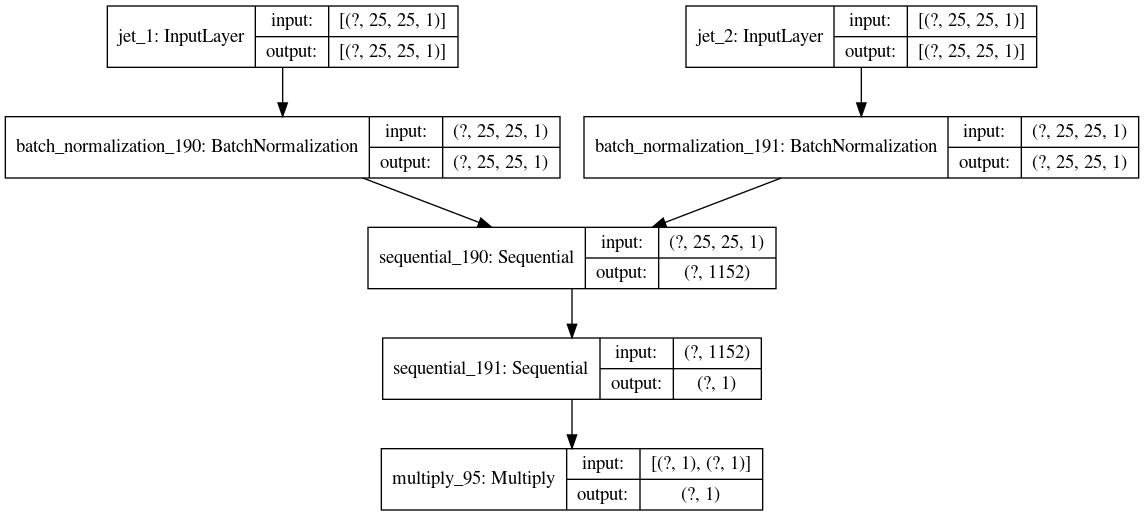

In [9]:
keras.utils.plot_model(loaded_model, "multi_input_and_output_model.png", show_shapes=True)

In [10]:
print(loaded_model.summary())

Model: "model_95"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
jet_1 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
jet_2 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_190 (BatchN (None, 25, 25, 1)    4           jet_1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_191 (BatchN (None, 25, 25, 1)    4           jet_2[0][0]                      
___________________________________________________________________________________________

In [37]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [38]:
bkg_sr_jet_1 = np.load('background_images_sr_25_jet_1.npy')
bkg_sr_jet_2 = np.load('background_images_sr_25_jet_2.npy')

signal_sr_jet_1 = np.load('id10_sr_25_jet_1.npy')
signal_sr_jet_2 = np.load('id10_sr_25_jet_2.npy')



In [39]:
signal_test_1 = signal_sr_jet_1[-20000:]
signal_test_2 = signal_sr_jet_2[-20000:]

bkg_test_1 = bkg_sr_jet_1[-20000:]
bkg_test_2 = bkg_sr_jet_2[-20000:]


test_label_signal = np.ones(np.shape(signal_test_1)[0])
test_label_bkg = np.zeros(np.shape(bkg_test_1)[0])

x_test_1 = np.concatenate((signal_test_1, bkg_test_1))
x_test_2 = np.concatenate((signal_test_2, bkg_test_2))
y_test = np.concatenate((test_label_signal, test_label_bkg))

x_test_1 = x_test_1.reshape((np.shape(x_test_1)[0],25,25,1))
x_test_2 = x_test_2.reshape((np.shape(x_test_2)[0],25,25,1))


In [40]:
x_predict = loaded_model.predict([x_test_1, x_test_2])


In [41]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]


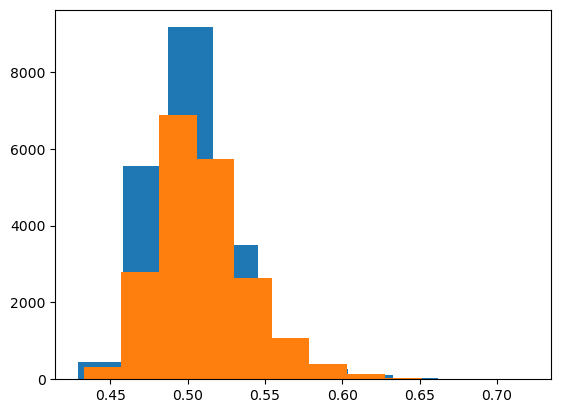

In [42]:
plt.hist(x_predict_0)
plt.hist(x_predict_1)
plt.show()

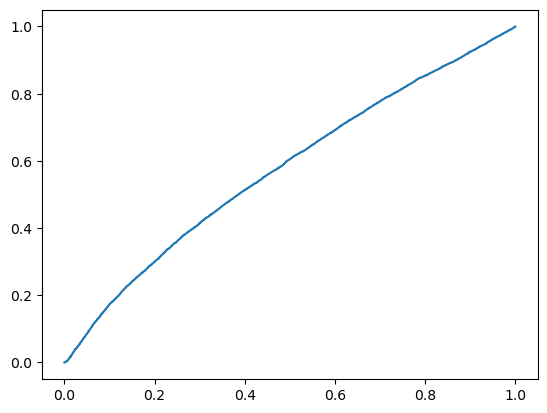

0.57545957


In [46]:
fpr, tpr, th = roc_curve(y_test, x_predict)
plt.plot(fpr, tpr)
plt.show()
f = interpolate.interp1d(fpr, tpr)
epsilon_s = f([0.001, 0.01, 0.1])
print(roc_auc_score(y_test, x_predict))

In [47]:
print(epsilon_s)

[0.0002875 0.0114    0.17335  ]


In [44]:
n_train_sr_signal = 500

In [45]:
print(np.sqrt(2*((n_train_sr_signal*epsilon_s[2]+25000*0.1)*np.log(n_train_sr_signal*epsilon_s[2]/(25000*0.1) + 1) - 
                 n_train_sr_signal*epsilon_s[2])))


1.7236252433607797
